# TDAC-seq tutorial

### In this tutorial, we show how to run our code on a small example dataset

A subset of cells will carry a CRISPR deletion at the target locus. Here we will first align reads, call DddA mutations, detect CRISPR deletions, and then analyze the effect of deletions on chromatin accessibility and footprints. We will also demonstrate the expected input and output format.

Each code cell in this notebook runs nearly instantaneously unless noted otherwise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tdac_seq.ddda_dataset import *
from tdac_seq.utils import *
%matplotlib inline
# runtime ~10-20 seconds

### 1. Align reads

In [2]:
# Create a dictionary for the target region(s) we are interested in
# Here we are only using one region, but you can have multiple regions
ref_range_dict = {
    'target_locus': ('chr7', 27158522, 27163197)
}

In [3]:
# Initialize the ddda_dataset object
# This is the main object for storing and processing data
ddda_data = ddda_dataset(
    ID = "tutorial", # Dataset ID 
    region_dict = ref_range_dict, # Provide target locus
    genome_file = "hg38.fa", # Provide genome fa file
    fastq_file = "tutorial_data.fastq", # Nanopore fastq file. Merged from individual smaller fastqs from the same run.
    working_dir = "tutorial/" # Directory for storing results
)
# runtime ~10-20 seconds

Loading reference genome
Extracting sequences for each locus


In [4]:
# Load DddA bias model. This is our pre-trained sequence bias model from naked DNA
with open("data/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)

In [5]:
# Align nanopore reads to the reference genome at the target locus.
# We define a gap threshold so that the unaligned region at the beginning and end of the read should be shorter than this value.
# For example, if our target region is chr1:10000-20000, and start_gap_threshold is 1000, end_gap_threshold is 500,
# then any read passing filter should have alignment start <= chr1:11000 and alignment end >= chr1:19500. 
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

# If you are doing an adenine base editor (ABE) perturbation instead of Cas9 deletion, you can set ABE_edits=True
# This will allow the recording of A-to-G mutations
'''
# Example
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold,
    ABE_edits=True
)
'''
print(ddda_data)
# runtime ~10 minutes on single CPU, ~1.5 minutes with 16 CPUs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162206/162206 [01:11<00:00, 2272.44it/s]


122522 reads aligned. 39684 reads unaligned


### 2. Retrieving alignment results

After alignment, you will have the following slots recording alignment data
They are dictionaries with the name of the locus in ref_range_dict as keys and alignment data as values

In [6]:
# CSR sparse matrix storing the DddA edit information
# If we have multiple loci, you can extract the results for each locus separately
locus = "target_locus"
ddda_data.edit_dict[locus]

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 14525374 stored elements and shape (122522, 4676)>

Text(0, 0.5, 'Average DddA edit rate')

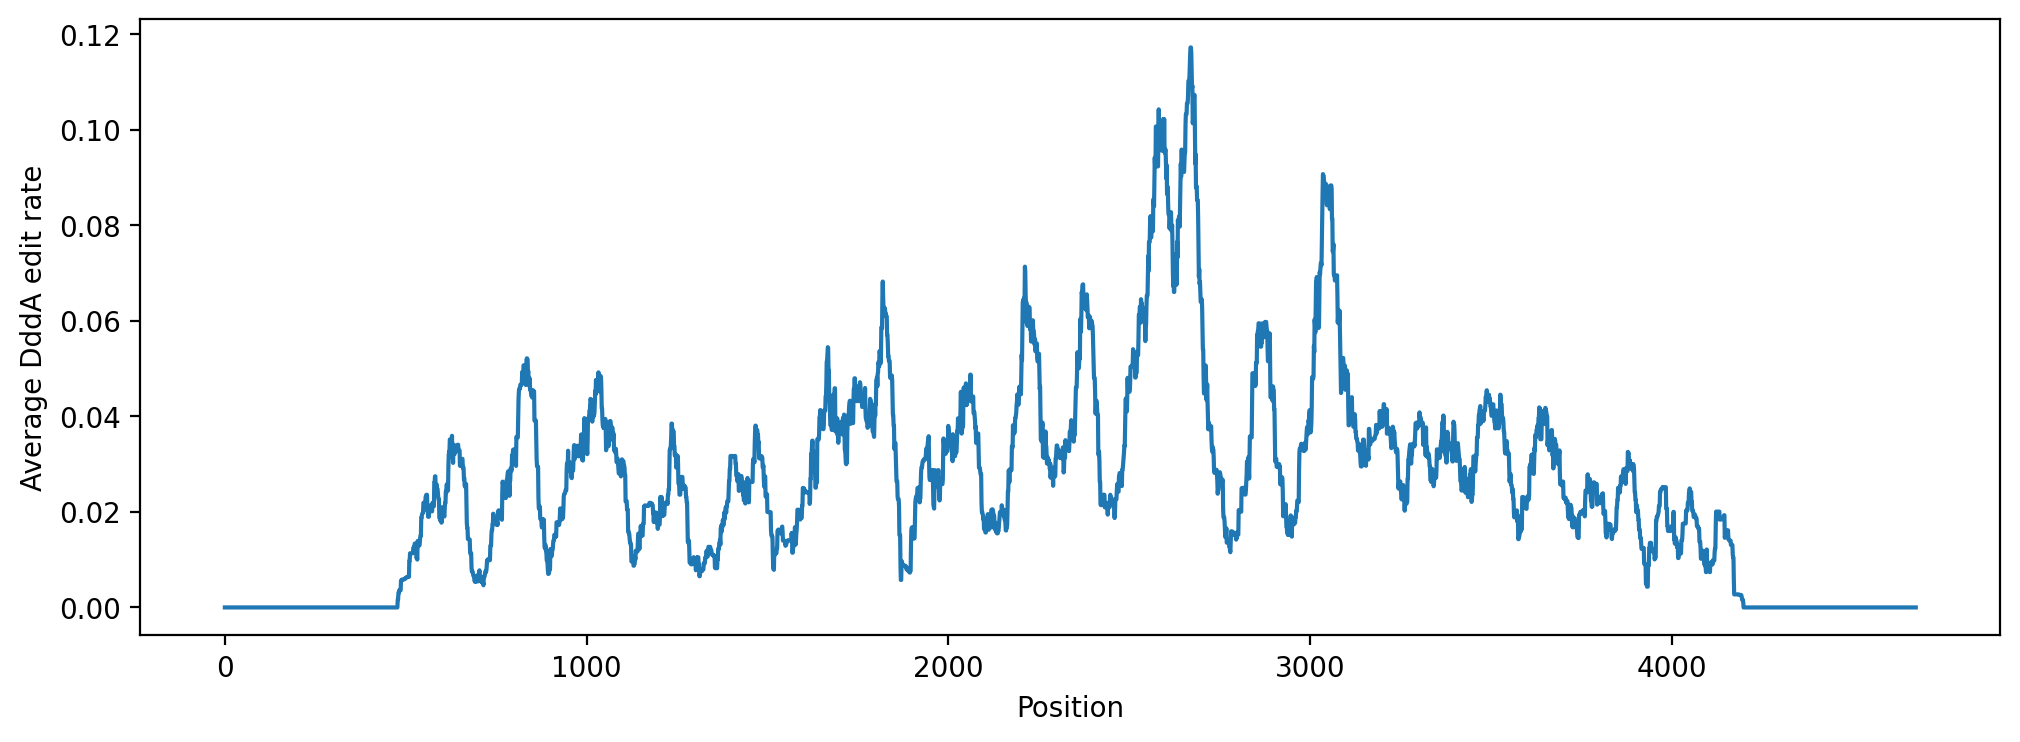

In [7]:
# We can calculate the average edits across all reads
plt.figure(dpi=200, figsize=(12, 4))
avg_edit = np.array(np.mean(ddda_data.edit_dict[locus], axis=0)).squeeze()

# Smooth the results
smooth_radius = 50
avg_edit_smoothed = np.convolve(
    avg_edit, 
    np.ones(smooth_radius),
    mode="same") / smooth_radius
plt.plot(avg_edit_smoothed)
plt.xlabel("Position")
plt.ylabel("Average DddA edit rate")

In [8]:
# CSR sparse matrix storing the CRISPR deletion intervals
# 0s are undeleted and 1s are deleted
ddda_data.del_dict[locus]

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 738304 stored elements and shape (122522, 4676)>

/n/home04/sps/.conda/envs/simon/envs/tdac-seq/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


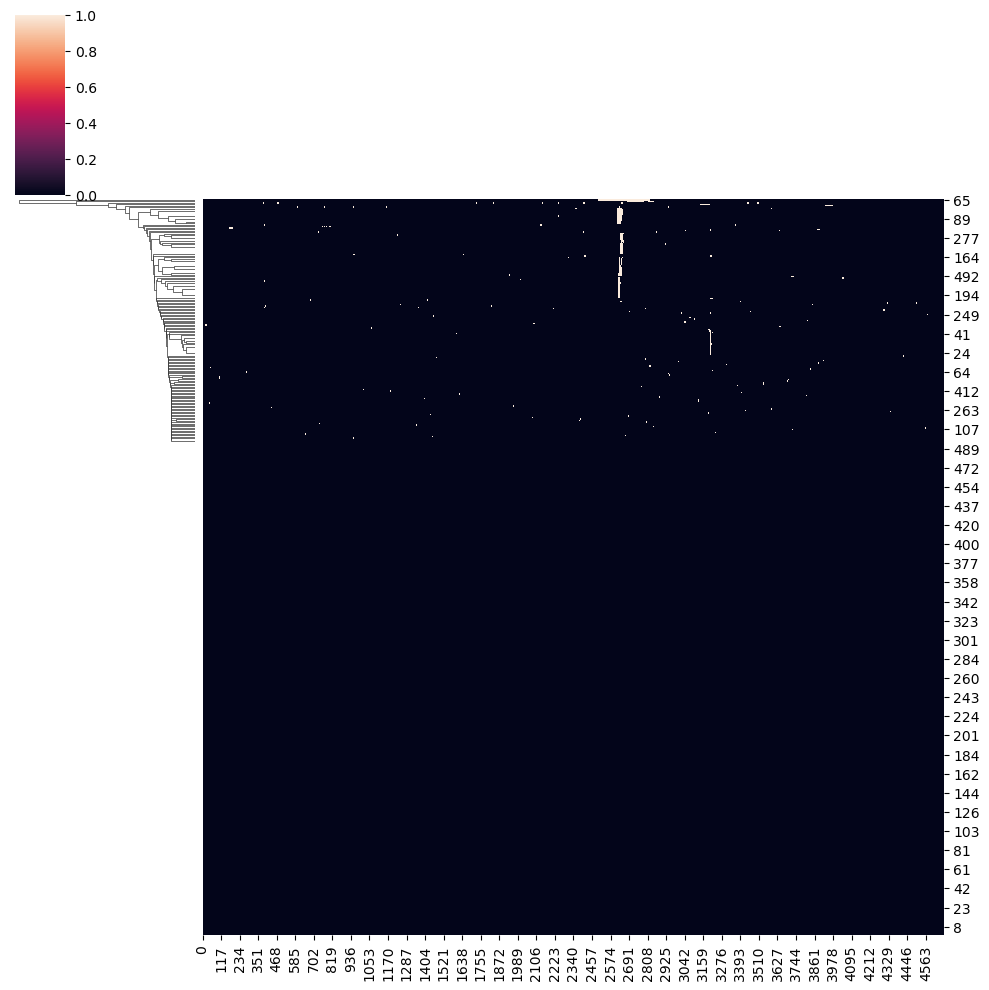

In [ ]:
# Let's check the deletions in the first 500 reads
# You can see that a small subset of reads actually carry a deletion around the CTCF site at around 2630
motif_start, motif_end = 2623, 2645
sample_del = np.array(ddda_data.del_dict[locus][:500,:].todense())
sns.clustermap(sample_del, col_cluster=False)

In [10]:
# Read IDs
print(ddda_data.read_ids[locus][:5])

['fec5e75a-c178-4e36-bcab-6f9eda58fdd6', 'ebc49fed-52b7-4c26-8316-ca337e1ced80', '73cbd1fc-7030-41d2-97c2-5dc58e8d7db8', '892470dd-884b-4a9d-bf13-a2ee656039fe', '4f3e2da1-10d5-4da5-b334-5c73cd5a9742']


In [11]:
# Read strands. 0 is C-to-T strand, and 1 is G-to-A strand.
print(ddda_data.read_strands[locus][:5])

[1 1 0 1 1]


In [12]:
# You can also access the genomic sequence of the target locus here
ddda_data.ref_seq_dict['target_locus'][:100]

'GGTGACACACAGCAAGACGCAAAGAGAAAAGACCAAGGCCCCCGCCGCCGCCGTCTGTCTAGACTCAAGCGACTGAAGGGGCCAACAGAGCTGGTGTTTA'

### 3. Exporting results to csv

In [ ]:
# We can export the data matrices to csv in case you want to share the data with others
# in a IJV three column sparse format
export_to_tsv(
    ddda_data, 
    export_DddA_edit=True, 
    export_del=True, 
    export_ABE_edit=False,
    export_dir="tutorial//")
# runtime ~10 seconds

Exporting DddA edits for dataset tutorial at locus target_locus
Exporting deletions for dataset tutorial at locus target_locus
Exporting aligned reads for dataset tutorial at locus target_locus


### 4. Analyze the effect of CRISPR deletion on chromatin accessibility

In [14]:
# Find reads where the sgRNA target site is covered by a deletion
del_start, del_end = motif_start, motif_end
del_matrix = ddda_data.del_dict[locus]
motif_del = np.array(np.max(del_matrix[:, del_start:del_end], axis=1).todense())[:, 0]
del_read_inds = np.where(motif_del == 1)[0]

# Only keep reads where positions outside of the vicinity of the sgRNA target site are not deleted
upstream_del = np.array(np.max(del_matrix[:, :del_start], axis=1).todense())[:, 0]
downstream_del = np.array(np.max(del_matrix[:, del_end:], axis=1).todense())[:, 0]
upstream_filter = upstream_del == 0
downstream_filter = downstream_del == 0
filter = np.where(upstream_filter & downstream_filter)[0]
del_read_inds = np.intersect1d(del_read_inds, filter)

# Separately, also find reads without any deletion as a control
undel_read_inds = np.where(np.array(np.max(del_matrix, axis=1).todense())[:, 0] == 0)[0]

# Down-sample the number of reads
min_num = min(len(del_read_inds), len(undel_read_inds))
del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

In [ ]:
# De-duplicate reads
del_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[del_read_inds]
)
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[undel_read_inds]
)
del_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in del_read_ids])
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])
# runtime ~10 seconds

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2618/2618 [00:00<00:00, 6453.12it/s]
2618it [00:00, 880709.65it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2618/2618 [00:00<00:00, 6480.32it/s]
2618it [00:00, 904206.84it/s]


In [16]:
# Combine deleted and undeleted reads 
selected_read_inds = np.concatenate([del_read_inds, undel_read_inds])
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.concatenate([np.ones(len(del_read_inds)), np.zeros(len(undel_read_inds))])
selection_dict = {locus:selected_reads}

#### 4.1 Examine the changes in accessibility

<Axes: >

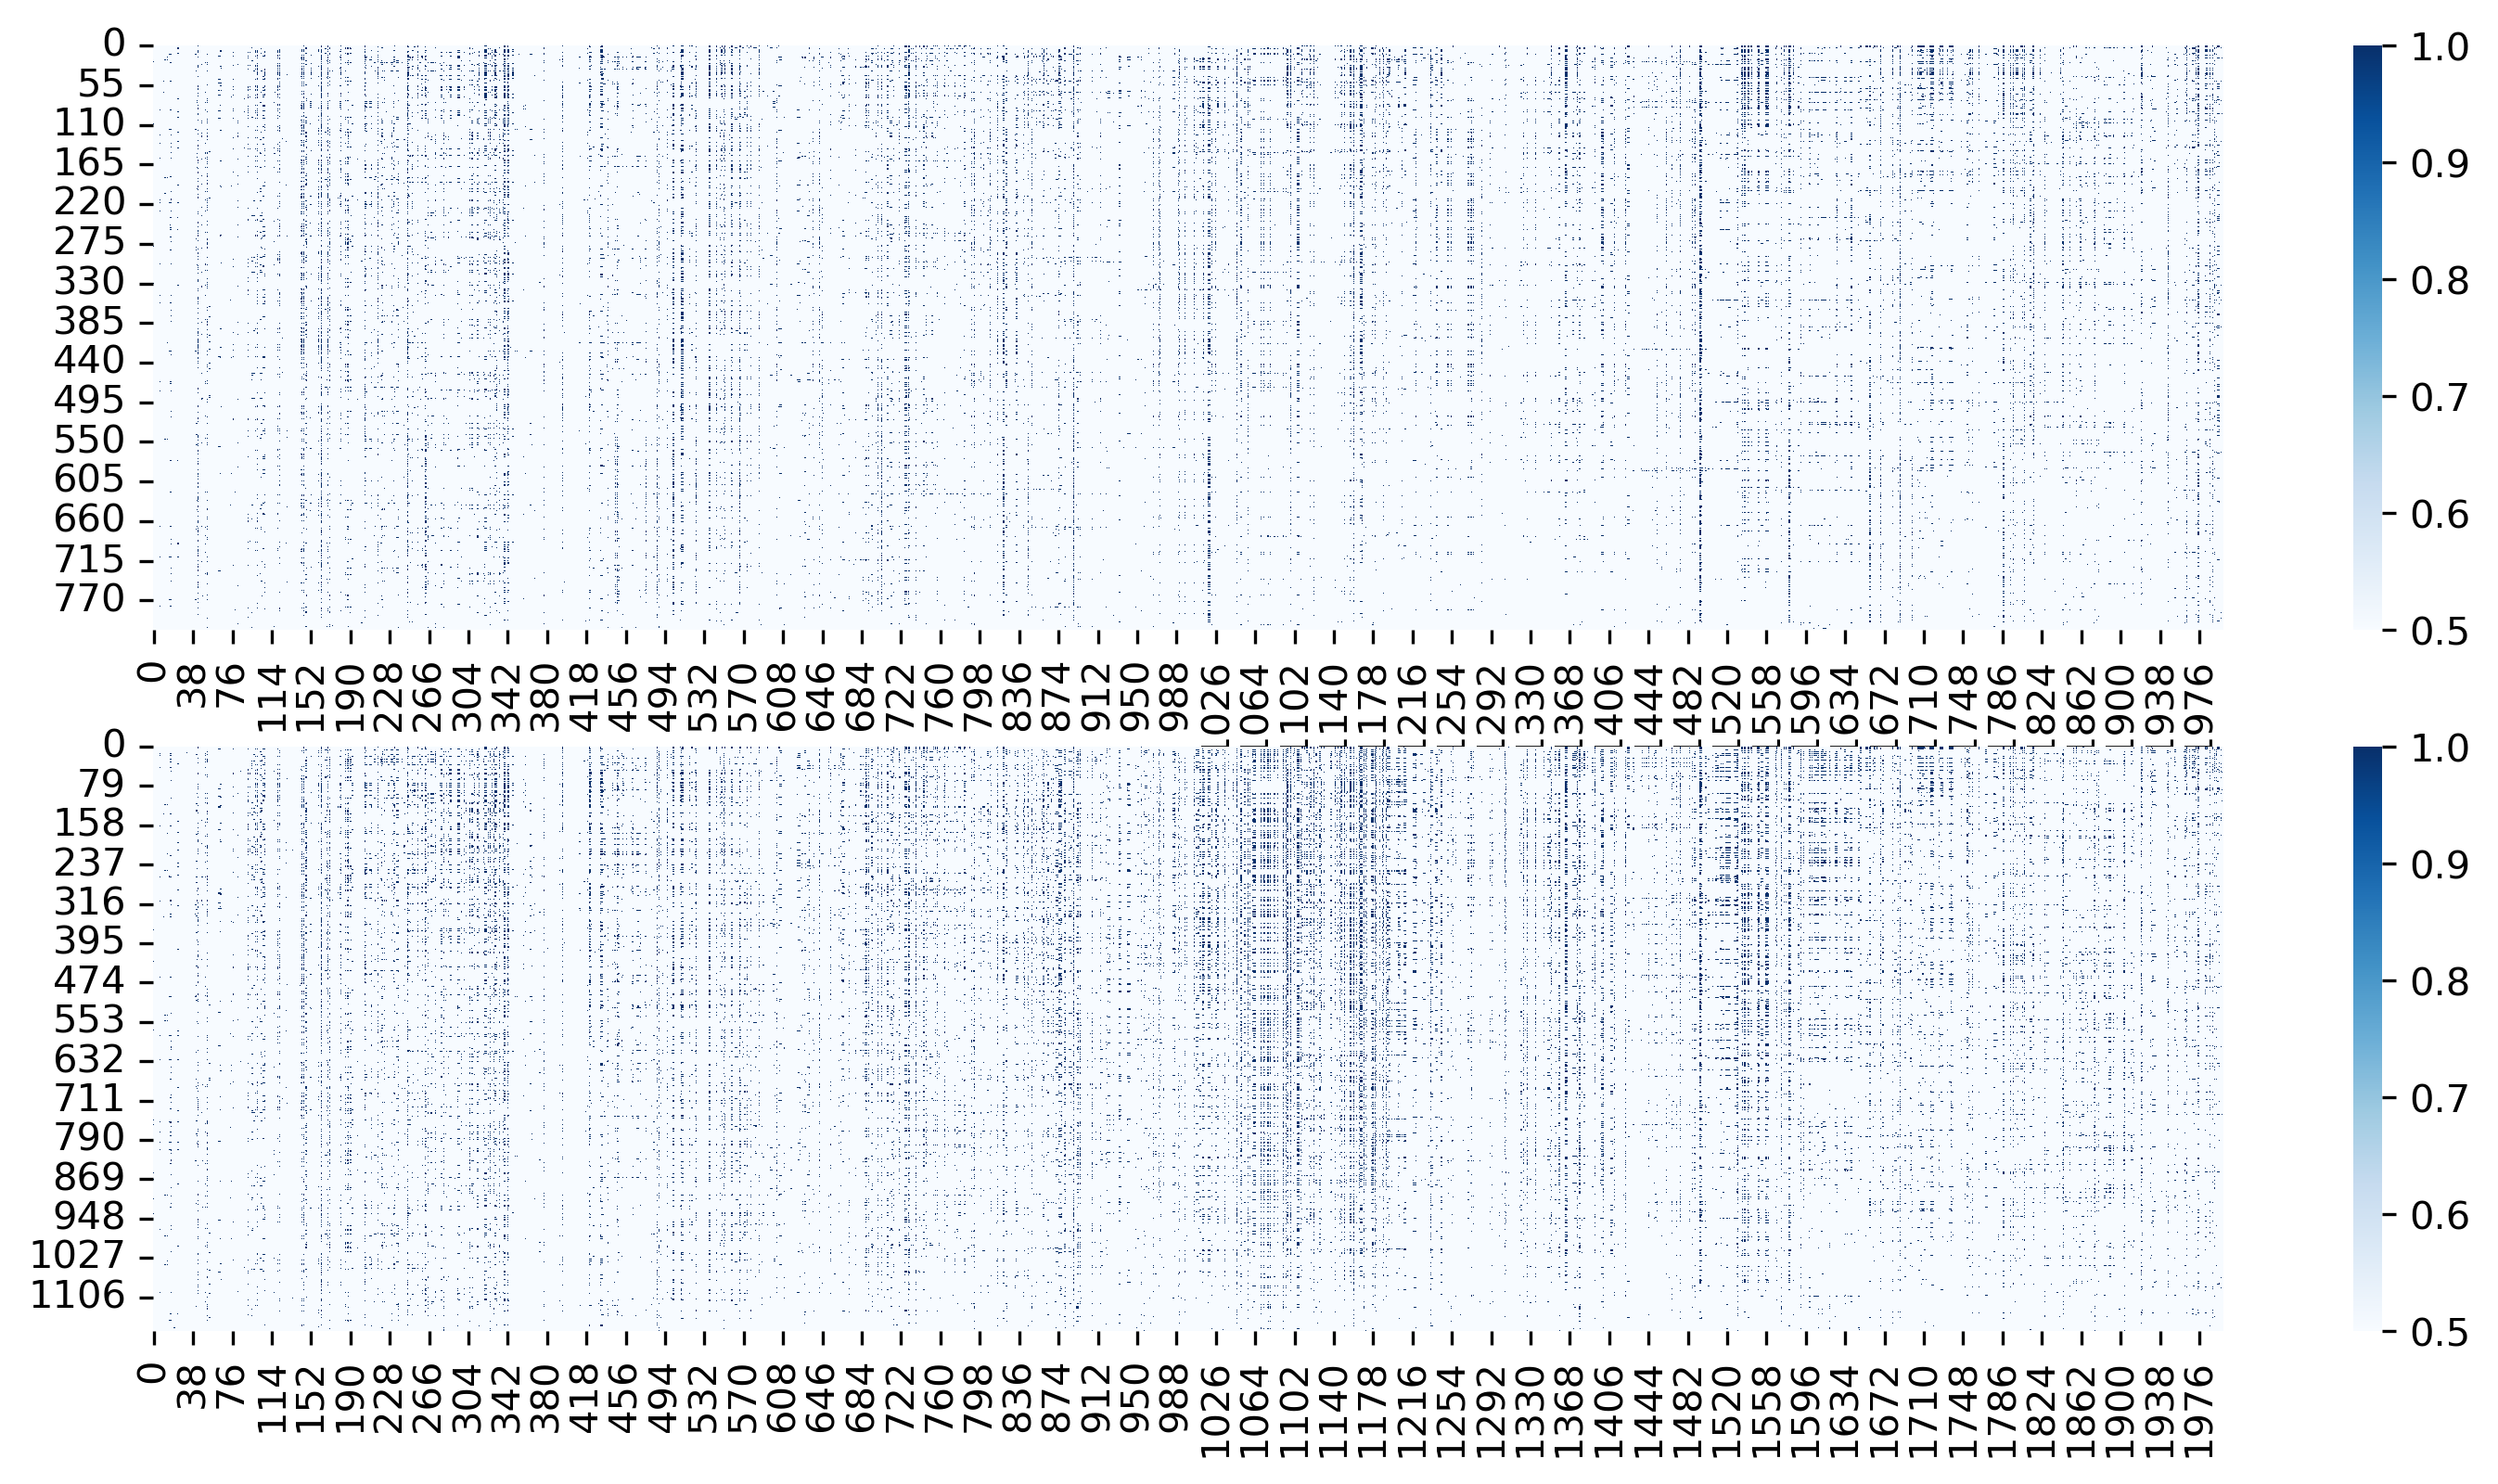

In [ ]:
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
plot_range = np.arange(1500, 3500)
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(12, 6))

# Plot edits of reads without deletion
del_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in del_filter]
sns.heatmap(
    ax = axes[0],
    data = edits[row_order, :][:, plot_range], 
    vmax = 1, vmin = 0.5, 
    cmap="Blues")

# Plot edits of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
sns.heatmap(
    ax = axes[1],
    data = edits[row_order, :][:, plot_range],
    vmax = 1, vmin = 0.5, 
    cmap="Blues")

# runtime ~10 seconds

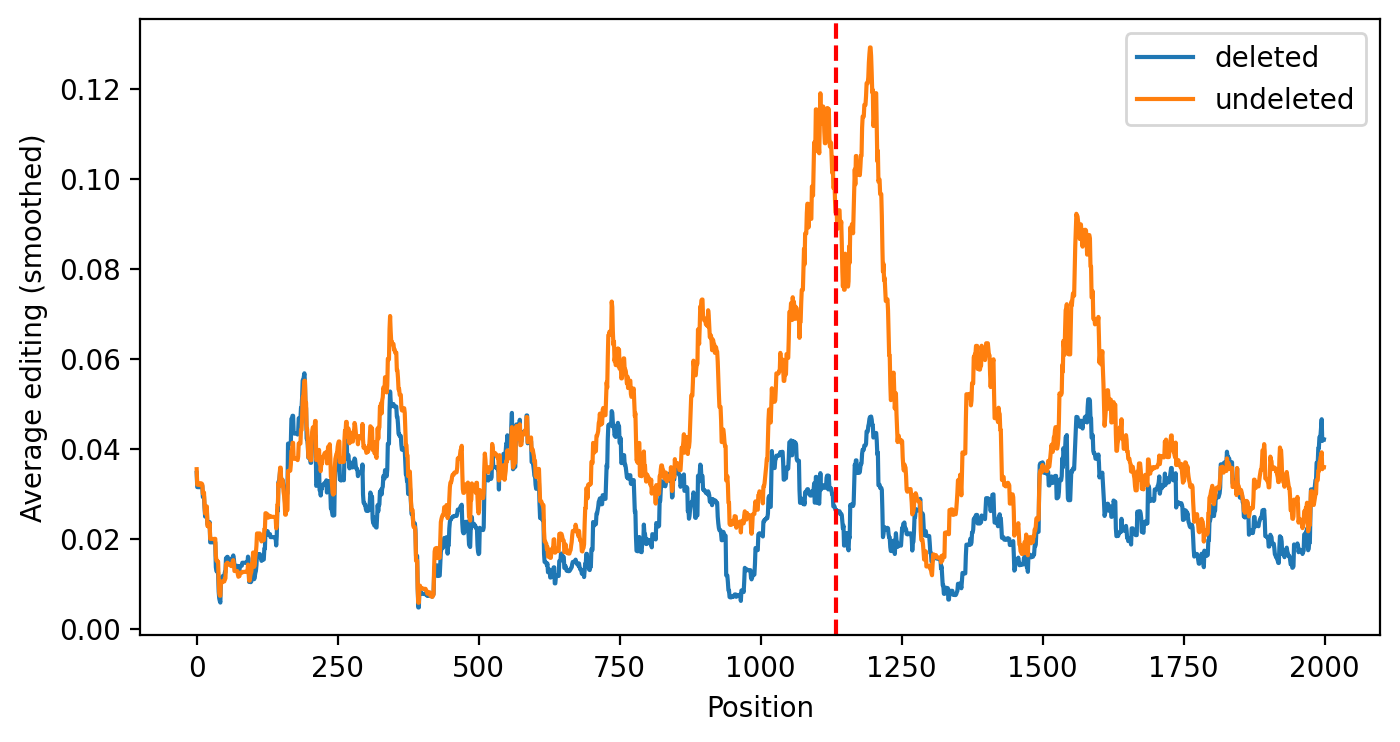

In [18]:
# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis = 0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50))/50
track_undeleted = np.convolve(track_undeleted, np.ones(50))/50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_deleted)), track_deleted, label="deleted")
plt.plot(np.arange(len(track_undeleted)), track_undeleted, label="undeleted")
plt.axvline(
    x = (motif_start + motif_end) / 2 - min(plot_range),
    ymin=0, ymax=1, linestyle="dashed", color="Red")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

#### 4.2 Examine the effects of Cas9 deletion on footprints

In [ ]:
# Calculate nucleosome footprints for individual reads
footprint_radius = 50
footprints_dict = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [footprint_radius], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp = -np.log10(fp)
# runtime ~5-10 seconds

Computing footprints for target_locus


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [00:06<00:00, 308.15it/s]


Below we can visualize the footprints of individual reads with and without a CRISPR deletion at the CTCF site. We can see a very clear loss of nucleosome footprint after deletion of the CTCF motif

<Axes: >

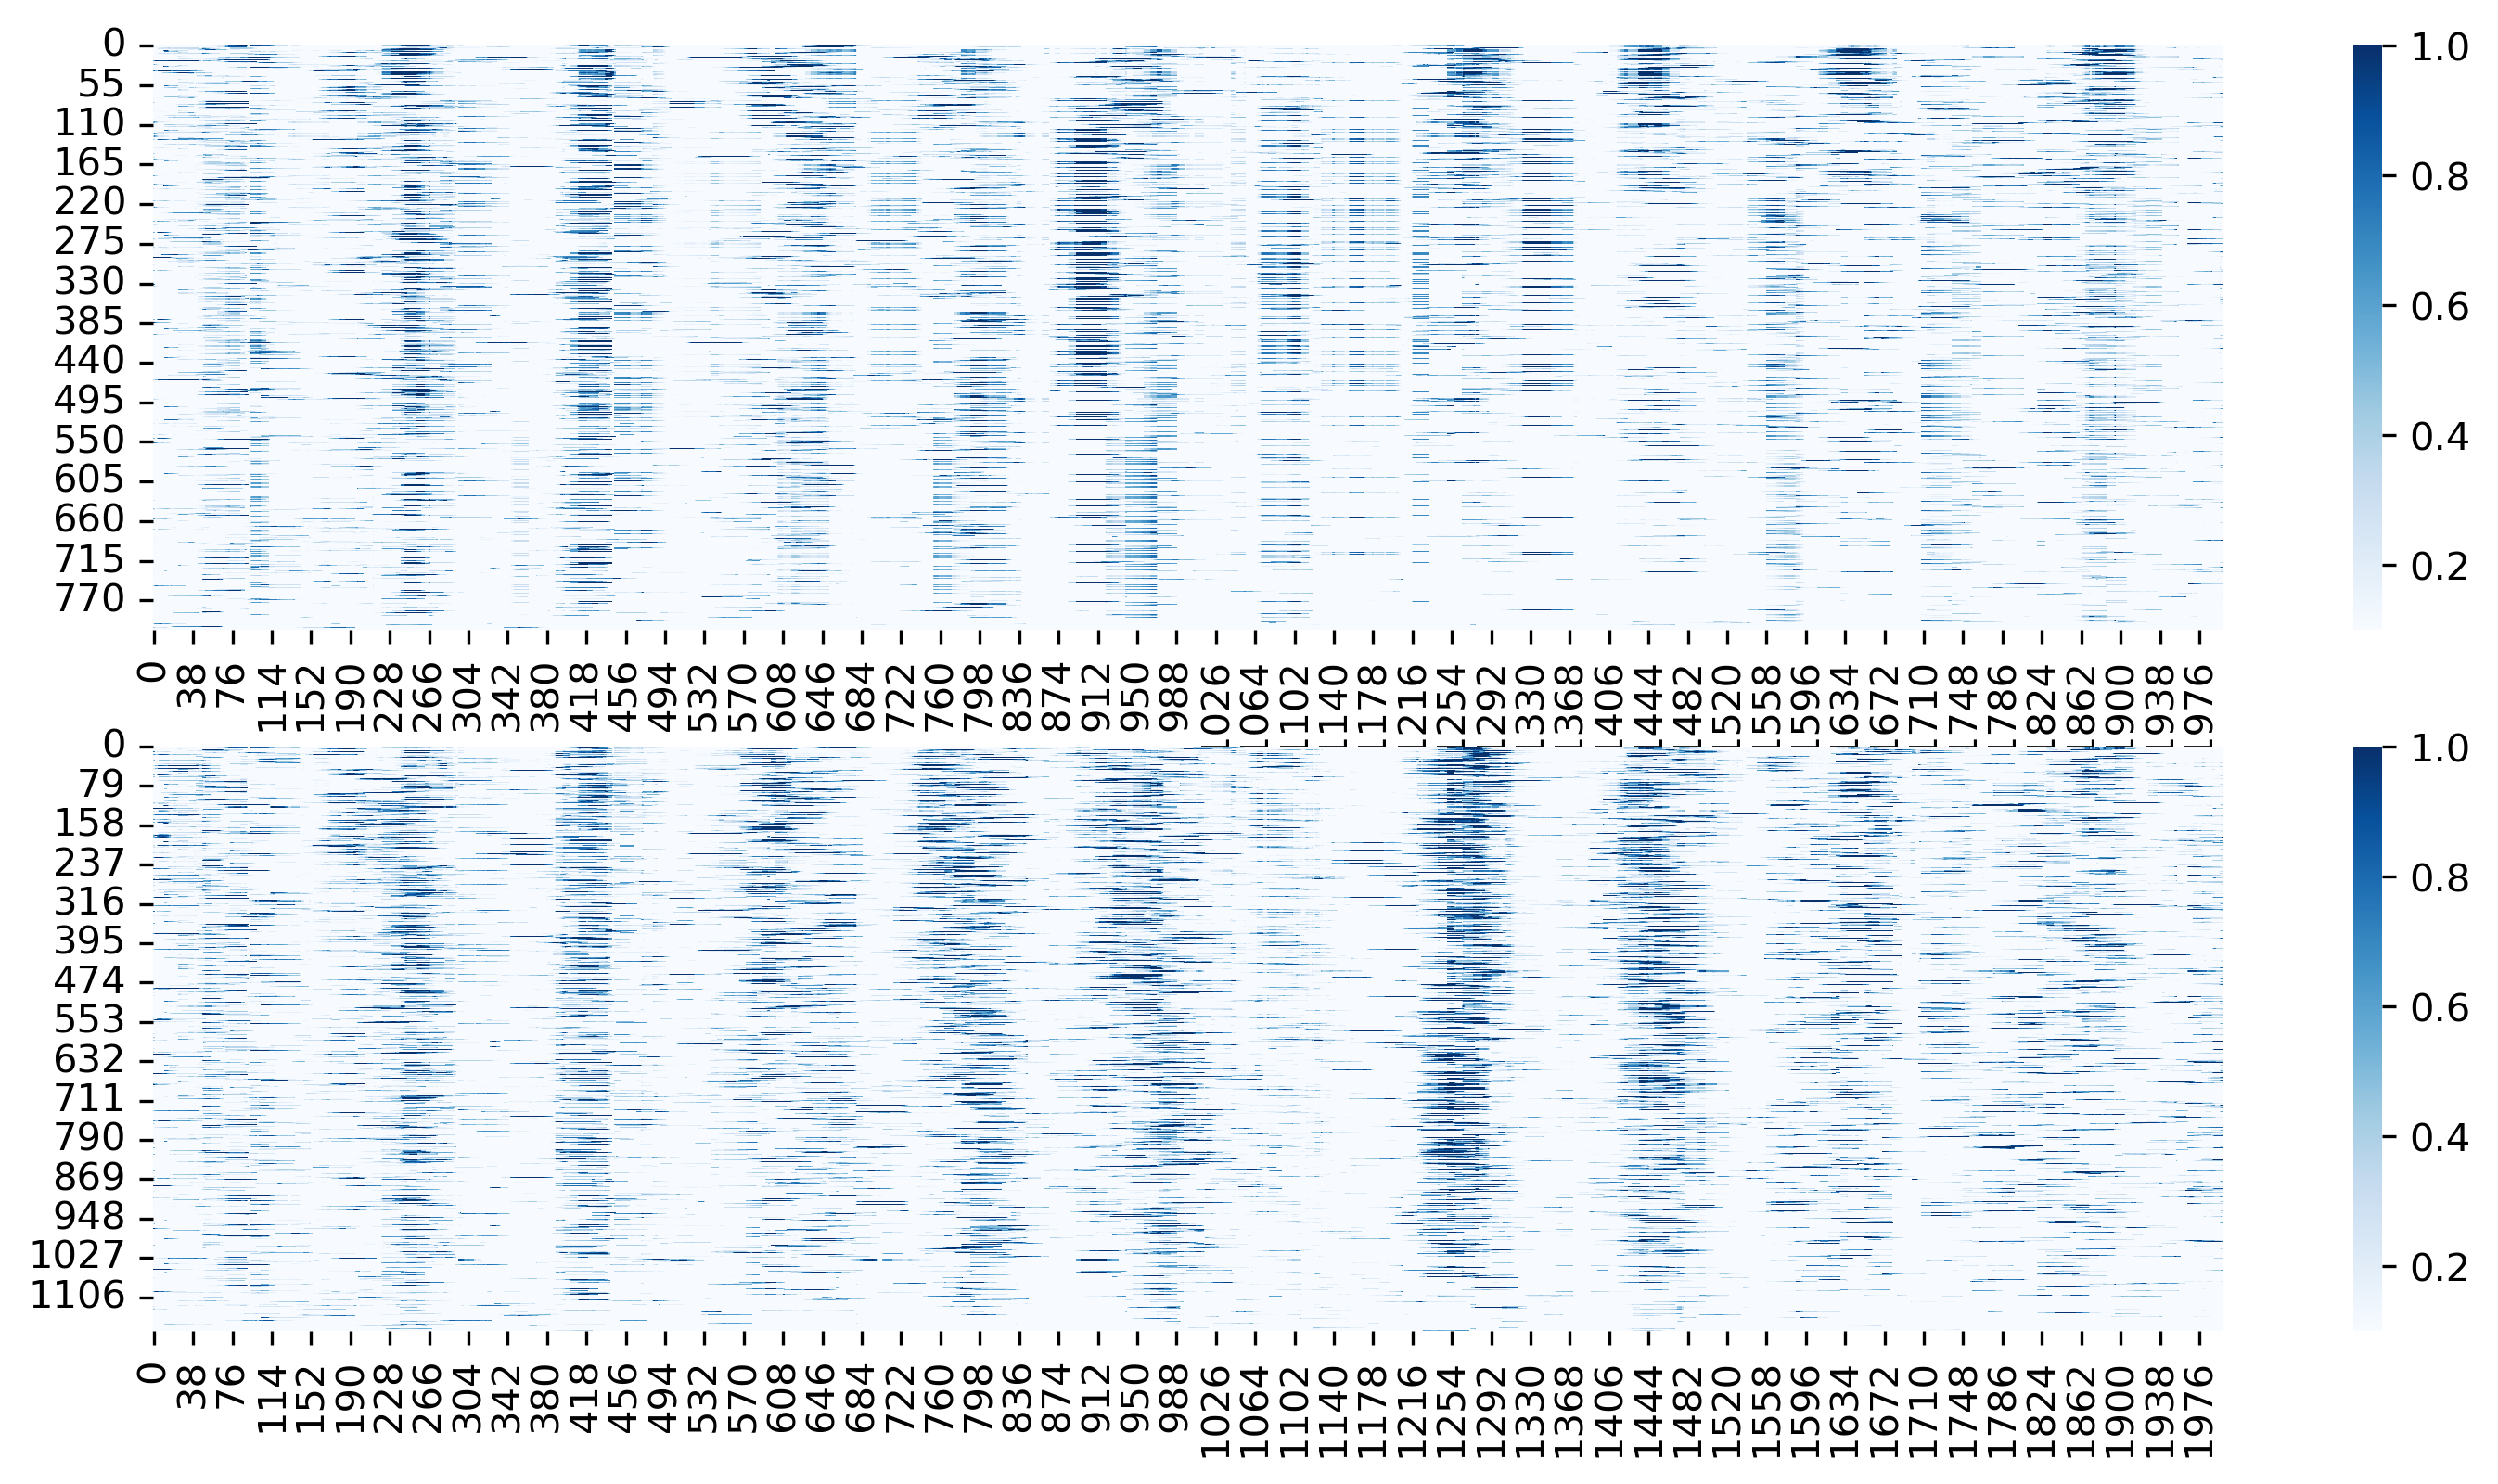

In [ ]:
# Visualize results
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(12, 6))

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads without deletion
del_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in del_filter]
sns.heatmap(
    ax = axes[0],
    data = fp[row_order, :][:, plot_range], 
    vmax = 1, vmin = 0.1, 
    cmap="Blues")

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
sns.heatmap(
    ax = axes[1],
    data = fp[row_order, :][:, plot_range],
    vmax = 1, vmin = 0.1, 
    cmap="Blues")
# runtime ~5-10 seconds

In the figure above, top is with deletion, bottom is without deletion (WT). We can also quantify the average change like below.

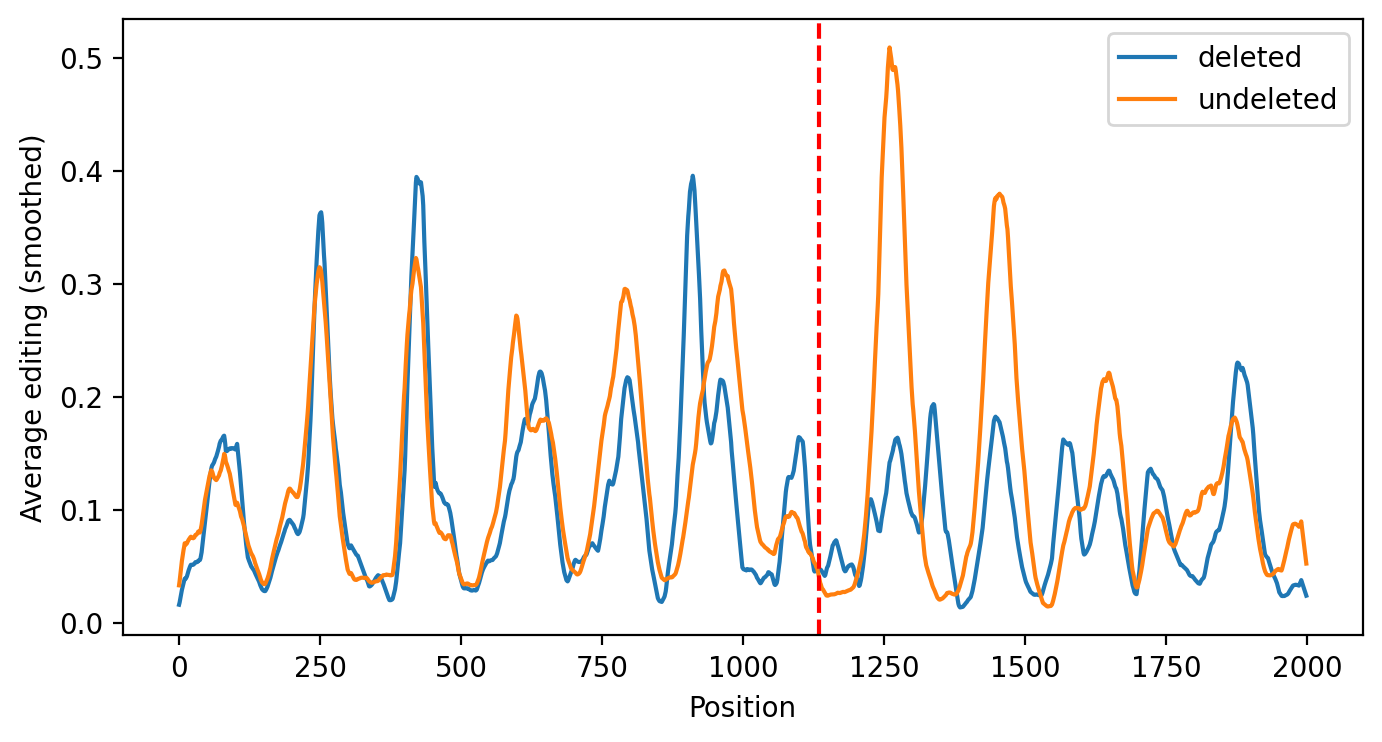

In [21]:
# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp[selected_del_flags == 1, :][:, plot_range], axis = 0)
track_deleted = np.convolve(
    track_deleted, 
    np.ones(smooth_radius),
    mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp[selected_del_flags == 0, :][:, plot_range], axis = 0)
track_undeleted = np.convolve(
    track_undeleted, 
    np.ones(smooth_radius), 
    mode="same") / smooth_radius

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_deleted)), track_deleted, label="deleted")
plt.plot(np.arange(len(track_undeleted)), track_undeleted, label="undeleted")
plt.axvline(
    x = (motif_start + motif_end) / 2 - min(plot_range),
    ymin=0, ymax=1, color = "Red", linestyle = "dashed")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

### Calculate multi-scale footprints

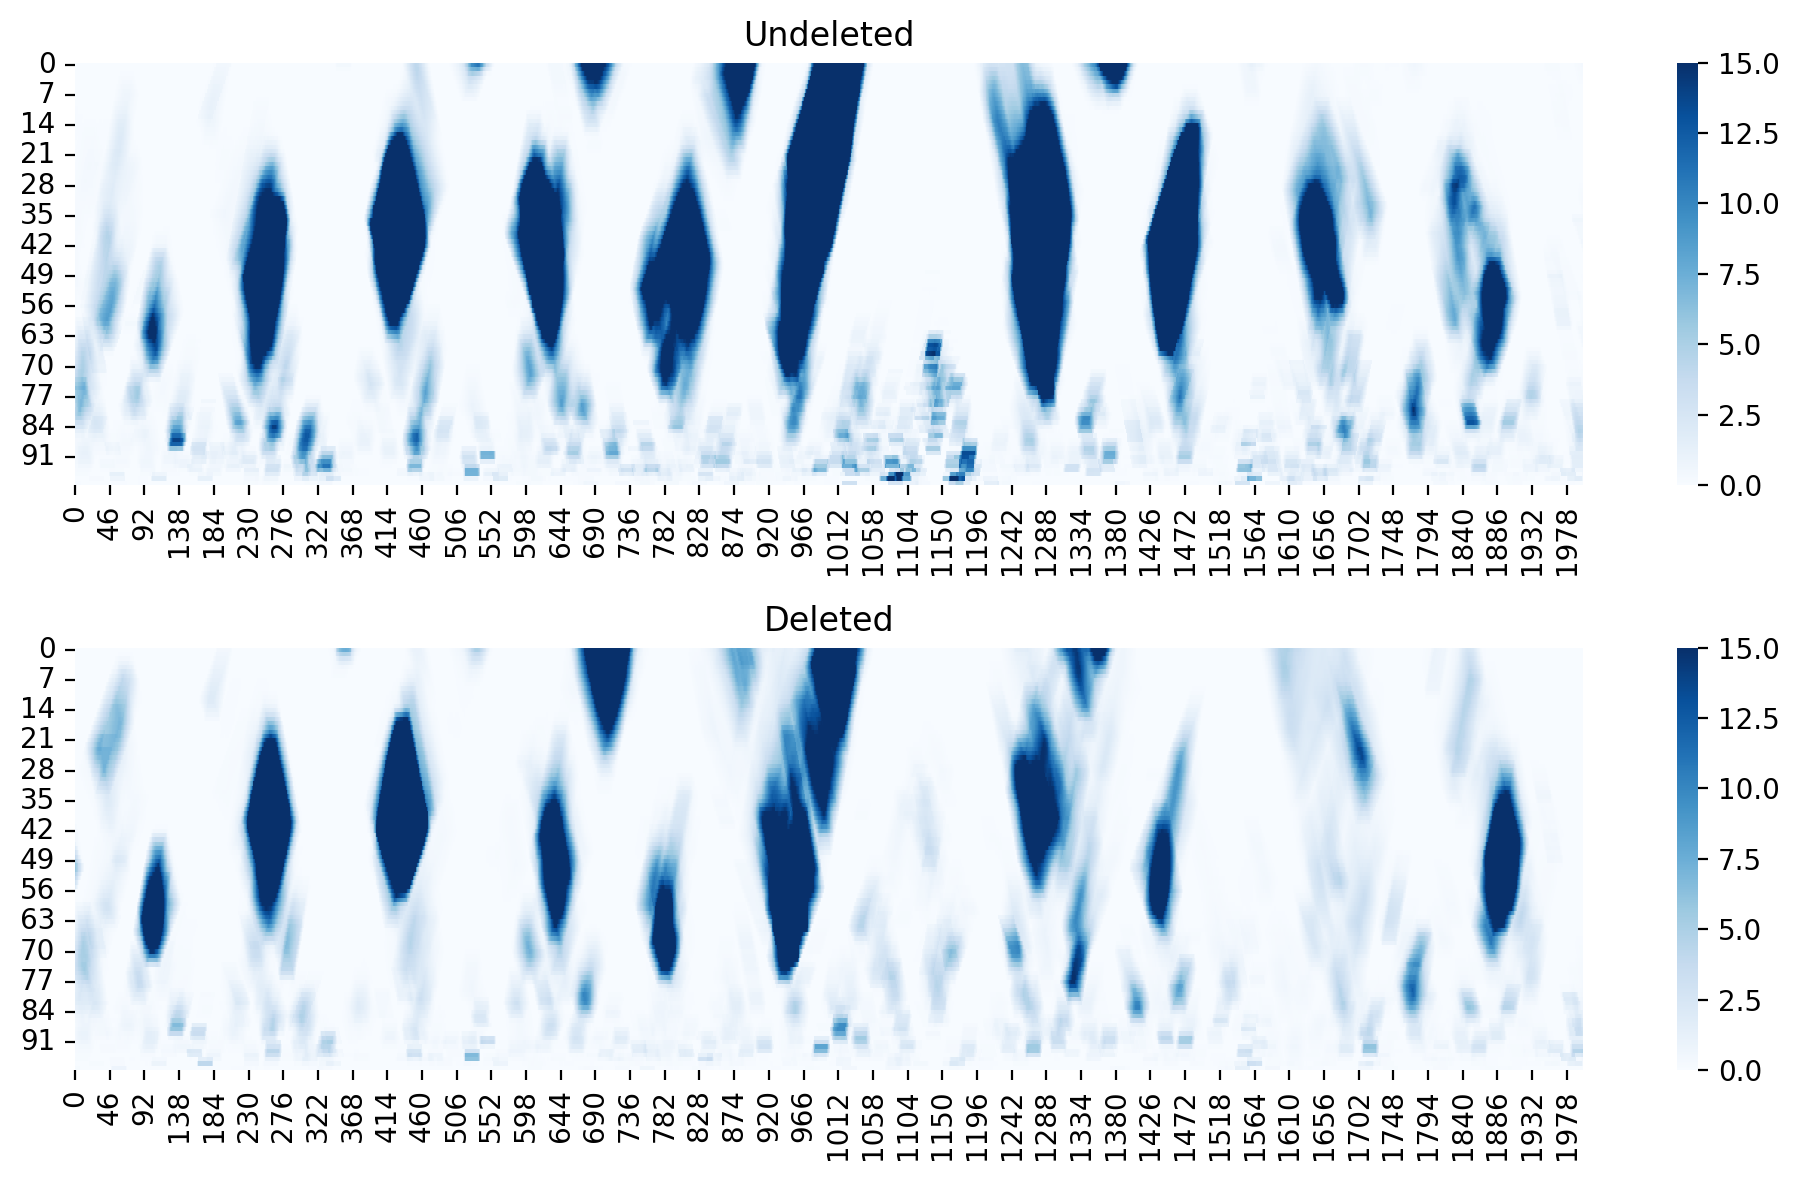

In [ ]:
footprint_dict = {}
for mode in ["del", "undel"]:
    read_inds = eval(mode + "_read_inds")
    footprint_dict[mode] = {}
    for strand_ind in range(2):

        # Get bias and edits on the selected strand
        strands = ddda_data.read_strands[locus][read_inds]
        bias = ddda_data.bias_dict[locus][:, strand_ind]
        agg_edits = np.array(np.sum(ddda_data.edit_dict[locus][read_inds[strands == strand_ind], :], axis=0))[0, :]
    
        # We mask the vicinity of the guide since the deletions might affect footprint calling
        agg_edits[del_start:del_end] = 0
        bias[del_start:del_end] = 0
    
        # Calculate footprints
        smooth_radius = 20
        footprints = np.array([get_footprint_single_scale(
            agg_edits, bias, fp_radius=r, combine_sides="max_pval") for r in np.arange(2, 100)])
        footprints = -np.log10(footprints + 1e-300)
        footprints = np.array([
            np.convolve(footprints[i, :], np.ones(smooth_radius)) / (2 * smooth_radius) \
            for i in np.arange(footprints.shape[0])])
        footprint_dict[mode][strand_ind] = footprints

undel_footprint = np.flip(footprint_dict["undel"][0][:, plot_range] +
                          footprint_dict["undel"][1][:, plot_range], axis=0)
del_footprint = np.flip(footprint_dict["del"][0][:, plot_range] +
                        footprint_dict["del"][1][:, plot_range], axis=0)
fig, axes = plt.subplots(2, 1, dpi=200, figsize=(10,6))
sns.heatmap(
    ax=axes[0], 
    data = undel_footprint,
    vmax=15, cmap = "Blues")
sns.heatmap(
    ax=axes[1], 
    data = del_footprint, 
    vmax=15, cmap = "Blues")
axes[0].set_title("Undeleted")
axes[1].set_title("Deleted")
plt.tight_layout()
plt.show()